In [1]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns;
sns.set(style="white", color_codes=True)

SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"
DATADIR="/storage/mgymrek/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure4"

Populating the interactive namespace from numpy and matplotlib


# STR Simulations

In [2]:
# Functions for plotting

def PlotExample(ex_data, fname, color="black"):
    lw=1
    boxprops = dict(color=color, linewidth=lw)
    medianprops = dict(color=color, linewidth=lw)
    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    bp = ex_data.boxplot(column="pt", by="gt", ax=ax, grid=False, boxprops=boxprops, medianprops=medianprops,
                return_type='dict');

    [[item.set_linewidth(lw) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['caps']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['caps']] for key in bp.keys()]

    ax.set_title("")
    plt.suptitle("");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("STR Genotype (bp relative to hg19)", size=20)
    ax.set_ylabel("Simulated phenotype", size=20);
    ax.set_xticklabels(ax.get_xticklabels(), size=15);
    ax.set_yticks(np.arange(-3, 3.1, 1))
    ax.set_yticklabels(ax.get_yticks(), size=15);
    fig.savefig(fname)
    
def PlotR2Pval(r2, assoc, fname):
    # Pull out SNPs
    str_coord = assoc[assoc["testclass"]=="STR"]["locus"].values[0]
    r2 = r2[r2["locus1"]==str_coord]
    r2["locus"] = r2["locus2"]
    snp_assoc = assoc[assoc["testclass"]=="SNP"]
    snp_assoc = pd.merge(snp_assoc, r2, on=["locus"])

    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    # Plotting all SNPs
    ax.scatter(snp_assoc["r2"], snp_assoc["pvalue"].apply(lambda x: -1*np.log10(x)), color="gray", s=8, label="SNPs");
    # Plot the STR
    ax.scatter([1.0], [assoc[assoc["testclass"]=="STR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]], color="red", s=40, label="STR")
    # Plot the imputed STR
    imp_ld = r2_imp[r2_imp["locus1"]==str_coord]["r2"].values[0]
    imp_p = assoc[assoc["testclass"]=="IMPSTR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]
    ax.scatter([imp_ld], [imp_p], color="blue", s=40, label="Imputed STR");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("R2 with causal STR", size=15)
    ax.set_ylabel("-log10 P", size=15);
    ax.set_xticklabels(["%.1f"%x for x in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12)
    ax.legend(loc="upper left");
    fig.savefig(fname)
    
def GetPower(x, alpha=0.05):
    return np.mean([(int(float(item) < alpha)) for item in x])

def PlotPower(assoc, fname, alpha=0.05, xlim=(0, 1), ylim=(0, 1)):
    # Calculate power for each class
    assoc_tmp = assoc.groupby(["str","testclass"], as_index=False).agg({"pvalue": lambda x: GetPower(x)})
    assoc_tmp["power"] = assoc_tmp["pvalue"]
    assoc_tmp = assoc_tmp[["str","testclass","power"]]
    impdata = assoc_tmp[assoc_tmp["testclass"]=="IMPSTR"].copy()
    snpdata = assoc_tmp[assoc_tmp["testclass"]=="SNP"].copy()
    strdata = assoc_tmp[assoc_tmp["testclass"]=="STR"].copy()
    impdata["imp_power"] = impdata["power"]
    snpdata["snp_power"] = snpdata["power"]
    strdata["str_power"] = strdata["power"]
    power = pd.merge(impdata[["str","imp_power"]], snpdata[["str", "snp_power"]], on=["str"])
    power = pd.merge(power, strdata[["str","str_power"]], on=["str"])
    power["powerdiff"] = power["imp_power"] - power["snp_power"]
    power["locus"] = power["str"]
    data = pd.merge(power, r2comp, on=["locus"])
    g = sns.jointplot(x="r2diff", y="powerdiff", data=data, xlim=xlim, ylim=ylim, stat_func=None, color="black", edgecolor="black", kind="kde")
    g.ax_joint.axvline(x=0, linestyle="dashed", color="gray")
    g.ax_joint.axhline(y=0, linestyle="dashed", color="gray")
    g.ax_joint.set_xlabel("r2imp-r2bestsnp", size=15)
    g.ax_joint.set_ylabel("powerimp-powerbestsnp", size=15)
    g.savefig(fname)
    print(data.shape[0])
    print(np.mean(data["r2diff"]))
    print(np.mean(data["powerdiff"]))
    print(np.mean(data["powerdiff"]>0))

In [3]:
# Load LD values
r2_snp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")
best_snp = r2_snp.groupby("locus1", as_index=False).agg({"r2": max, "freq_het": np.mean})
r2comp = pd.merge(best_snp, r2_imp, on=["locus1"])[["locus1","freq_het_x","r2_x","r2_y"]]
r2comp.columns = ["locus","het","r2_bestsnp","r2_ssc"]
r2comp["r2diff"] = r2comp["r2_ssc"]-r2comp["r2_bestsnp"]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/s1saini/.local/lib/python3.4/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  s)


2106
0.17671083911799743
0.11041785375118708
0.7725546058879392


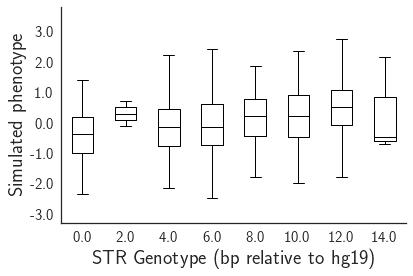

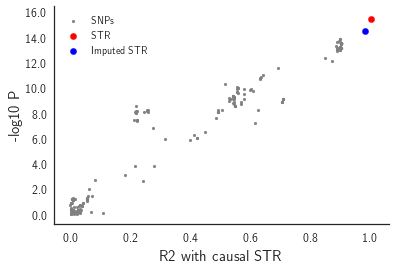

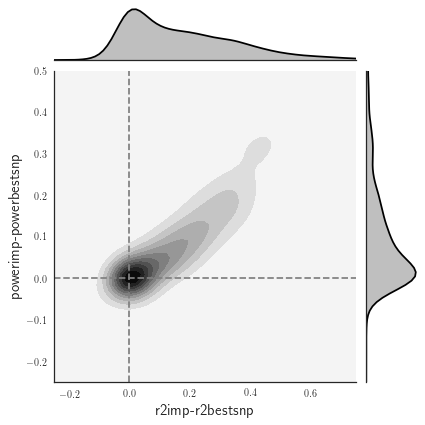

In [4]:
# Linear association
ex_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example.gt"), sep="\t")
ex_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(ex_gt_data, ex_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant.tab_power_simulation_results.txt"), sep="\t")
exassoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_power_simulation_results.txt"), sep="\t")

PlotExample(ex_data, os.path.join(OUTPATH, "%s_ExampleAssociation.pdf"%PREFIX))
PlotR2Pval(r2_snp, exassoc, os.path.join(OUTPATH, "%s_r2vsP.pdf"%PREFIX))
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerQuant.pdf"%PREFIX), xlim=(-0.25, 0.75), ylim=(-0.25, 0.5))

In [5]:
# Mean gain in r2 vs. num alleles
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.results.csv"))
sscloo["locus"] = sscloo["pos"]
ldata = pd.merge(sscloo, r2comp, on=["locus"])
print(np.mean(ldata[(ldata["numAllele"]>=3)]["r2diff"]))
print(np.mean(ldata["r2diff"]))
print(np.mean(ldata["r2_ssc"]))
print(np.mean(ldata["r2_bestsnp"]))

0.19208581025369087
0.1765477122266534
0.9162909259509048
0.7397432137242514


/home/s1saini/.local/lib/python3.4/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  s)


5427
0.17792588043349442
0.049355076469504336
0.7254468398747006


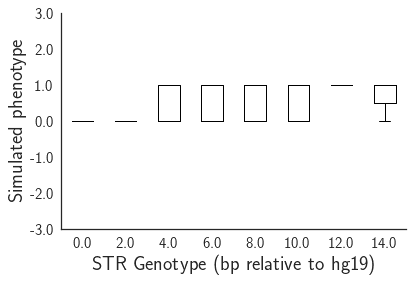

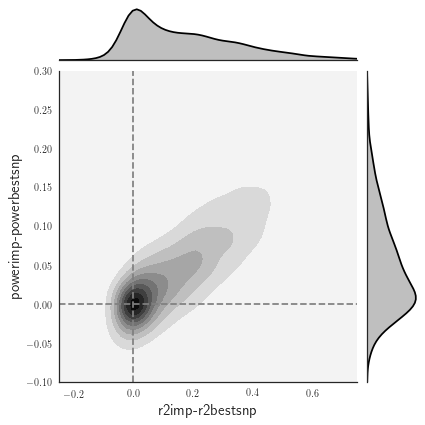

In [6]:
# Case control
ex_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example.gt"), sep="\t")
ex_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(ex_gt_data, ex_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_casecontrol.tab_power_simulation_results.txt"), sep="\t")
exassoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_power_simulation_results.txt"), sep="\t")

PlotExample(ex_data, os.path.join(OUTPATH, "%s_CCExampleAssociation.pdf"%PREFIX))
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerCC.pdf"%PREFIX), xlim=(-0.25, 0.75), ylim=(-0.1, 0.3))

/home/s1saini/.local/lib/python3.4/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  s)


5784
0.17644800861568083
0.17611671696215267
0.6051175656984785


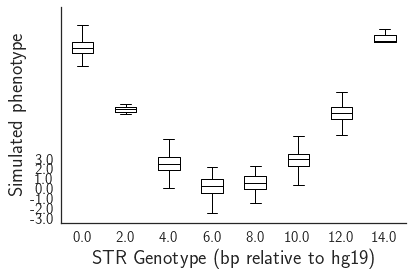

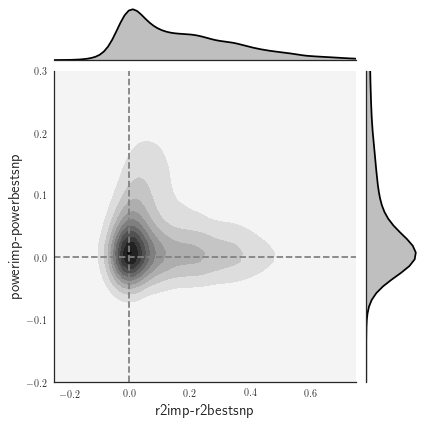

In [7]:
# Non-additive
SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"

exp_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_23934706_pb_allelic.gt"), sep="\t")
exp_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_23934706_pb_allelic_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(exp_gt_data, exp_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]

assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_pb_allelic_b0.1_power_simulation_results.txt"), sep="\t")
assoc_filt = assoc.groupby(["simnum", "str", "testclass"],  as_index=False).pvalue.min()

PlotExample(ex_data, os.path.join(OUTPATH, "%s_NonADDExampleAssociation.pdf"%PREFIX))
PlotPower(assoc_filt, os.path.join(OUTPATH, "%s_GWASPowerNonADD_Allelic.pdf"%PREFIX), xlim=(-0.25, 0.75), ylim=(-0.2, 0.3))

/home/s1saini/.local/lib/python3.4/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  s)


5784
0.17644800861568083
0.023407676348547714
0.3350622406639004


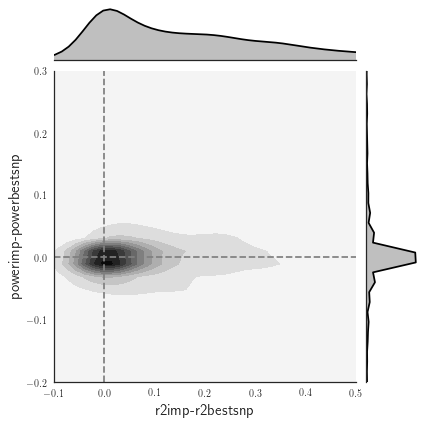

In [8]:
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "suppl_chr21_pb_b0.1_power_simulation_results.txt"), sep="\t")
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerNonADD.pdf"%PREFIX), xlim=(-0.1, 0.5), ylim=(-0.2, 0.3))

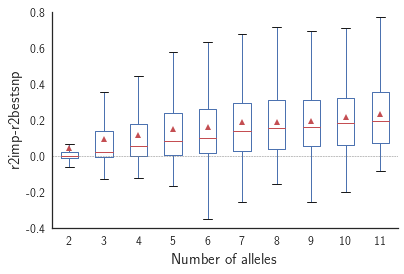

In [9]:
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ldata[ldata["numAllele"]<=10].boxplot(column="r2diff", by="numAllele", grid=False, ax=ax, showmeans=True);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.axhline(y=0, linestyle="dashed", color="gray", linewidth=0.5)
ax.set_ylim(bottom=-0.4, top=0.8)
ax.set_title("")
plt.suptitle("")
ax.set_xlabel("Number of alleles", size=15)
ax.set_ylabel("r2imp-r2bestsnp", size=15)
ax.set_xticklabels(ax.get_xticks()+1, size=12)
ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_r2gain.pdf"))

# Gene Expression 

In [10]:
def gen_qq(pval1, pval2=[], outputFileName=None, marker='.', color1='red', label1='_nolegend_', xlabel="Expected Values (-log10)", ylabel="Observed Values (-log10)", xlim=None, ylim=None, xticksFormat=None, yticksFormat=None, diagonal=False, lr=False, legend=False, alpha=None, empty=False):   
    fig = plt.figure()
    ax=fig.add_subplot(111)
    
    Y = -1*np.log10(np.sort(pval1))
    X = -1*np.log10(1.0*np.array(range(len(Y)))/len(Y))
    
    if empty is True:
        X = [np.min(X), np.max(X)]
        Y = [np.min(Y), np.max(Y)]
    
    ax.scatter(X, Y, marker=marker, color=color1, label=label1, alpha=alpha)
    
    if len(pval2) > 0:
        for pval2_values in pval2:
            Y_2 = -1*np.log10(np.sort(pval2_values[0]))
            X_2 = -1*np.log10(1.0*np.array(range(len(Y_2)))/len(Y_2))
            ax.scatter(X_2, Y_2, marker=marker, color=pval2_values[1], label=pval2_values[2], alpha=alpha)
        
        
    ax.set_xlabel(xlabel, size=15)
    ax.set_ylabel(ylabel, size=15)

    if diagonal is True:
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle="dashed", color="black", label="_nolegend_")
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    if lr is True:
        m,b=np.polyfit(X, Y, 1)
        X_plot=np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.plot(X_plot, m*X_plot+b, linestyle="dashed", color="blue", label="Best fit")

    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.set_yticklabels(ax.get_yticks(), size=12);
    
    if xticksFormat is not None:
        ax.set_xticklabels([xticksFormat%(x) for x in ax.get_xticks()], size=10);
    if yticksFormat is not None:
        ax.set_yticklabels([yticksFormat%(x) for x in ax.get_yticks()], size=12);
    
    if legend is True:
        legend = ax.legend(loc="best")
        
    if outputFileName is not None:
        fig.savefig(os.path.join(OUTPATH, outputFileName))

In [11]:
chrom="21"
TISSUE = "WholeBlood"

# Conversion files
raw_values_id_to_pos = pd.read_csv("/storage/s1saini/manuscript_strsnp/gtex/chr"+chrom+"_pos_to_id_raw.txt", names=['str.start','str.id'], delim_whitespace=True)
imputed_values_id_to_pos = pd.read_csv("/storage/s1saini/manuscript_strsnp/gtex/chr"+chrom+"_pos_to_id_imputed.txt", names=['str.start','str.id'], delim_whitespace=True)

raw_values = pd.read_csv("/storage/mgymrek/ssc-imputation/gtex-power/hipstr_gtex_strgts_chr21_linreg_%s.tab"%TISSUE, delimiter="\t").drop(['str.id'], axis=1)
raw_values = pd.merge(raw_values, raw_values_id_to_pos, on="str.start", how="inner")

imputed_values = pd.read_csv("/storage/mgymrek/ssc-imputation/gtex-power/imputed_gtex_strgts_chr21_linreg_%s.tab"%TISSUE, sep="\t")
imputed_values = pd.merge(imputed_values, imputed_values_id_to_pos, on="str.start", how="inner")
imputed_values["str.id"] = imputed_values["str.id_y"]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


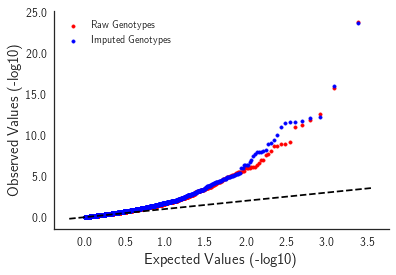

In [12]:
# Figure 3D: QQ plot
intersection_raw_values = raw_values[raw_values['str.id'].isin(imputed_values['str.id'].values.tolist())]
intersection_imputed_values = imputed_values[imputed_values['str.id'].isin(raw_values['str.id'].values.tolist())]
gen_qq(intersection_raw_values['p.wald'].values, [(intersection_imputed_values['p.wald'].values, "blue", "Imputed Genotypes")], label1 = "Raw Genotypes", legend = True, \
       diagonal=True, marker=".", outputFileName="%s_GTExQQ.pdf"%PREFIX)

In [13]:
DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
sscloo["loo_r2"] = sscloo["loo_r"]**2
sscloo["wgs_eur_r2"] = sscloo["wgs_eur_r"]**2
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","pos"]).drop_duplicates(subset=['pos'])
position_to_id = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/position_to_id/ALL.position_to_id.txt", names=["pos", "str"], delim_whitespace=True)
sscloo = pd.merge(sscloo[["str","loo_concordance","wgs_eur_concordance","wgs_eur_r2", "loo_r2","loo_r"]], id_start, on=["str"])

In [14]:
# compare to NG
NGESTR = pd.read_csv('/storage/szfeupe/Runs/GTEx_estr/2016_estrs_table.csv',sep=',')
NGESTR["str.start"] = NGESTR["str.start"]-1
NGESTR["gene2"] = NGESTR["gene"]
imputed_values["gene2"] = imputed_values["gene"].apply(lambda x: x.split(".")[0])
vsng = pd.merge(imputed_values, NGESTR, on=["gene2","str.start"])
vsng = vsng[vsng["signif.estr"]]

97
(0.988485408261926, 1.0138659379831835e-79) 97
(0.7856840697804396, 0.00415230350567912) 11


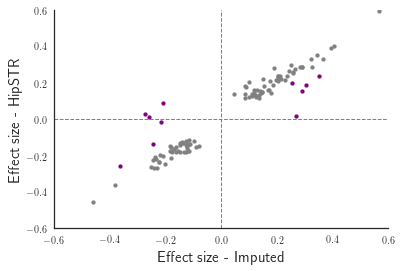

In [15]:
# Figure 3: Effect sizes for significant ones
min_col = 'p.wald'
MINVAL = 0.05

sig_raw_values = raw_values[raw_values[min_col] < MINVAL].reset_index()
sig_raw_values = sig_raw_values.iloc[sig_raw_values.groupby('gene').agg({min_col:'idxmin'})[min_col]]#[['gene','str.id', 'beta', min_col]]

# Merge, "_x" gives hipstr, "_y" gives imputed, only look at significant ones
imputed_raw = pd.merge(sig_raw_values, imputed_values, how="inner", on=['gene','str.id'])
imputed_raw["pos"] = imputed_raw.apply(lambda x: x["chrom_x"].replace("chr","")+":"+str(x["str.start_x"]), 1)
imputed_raw = pd.merge(imputed_raw, sscloo, on=["pos"])

# How many significant eSTRs also had imputed data
print(imputed_raw.shape[0])

def GetColor(x):
    return ["gray","red"][int(np.sign(x["beta_x"])==np.sign(x["beta_y"]))]

sizes = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(imputed_raw['beta_y'], imputed_raw['beta_x'], color="gray", s=sizes) #imputed_raw.apply(GetColor, 1)
ax.scatter(vsng["beta_y"], vsng['beta_x'], color="purple", s=sizes) #imputed_raw.apply(GetColor, 1)

ax.axhline(y=0, linestyle="dashed", color="gray", linewidth=1)
ax.axvline(x=0, linestyle="dashed", color="gray", linewidth=1)
#ax.plot([-0.5,0.5],[-0.5,0.5], linestyle="dashed", color="gray")
ax.set_xlim(left=-0.6, right=0.6)
ax.set_ylim(bottom=-0.6, top=0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Effect size - Imputed", size=15)
ax.set_ylabel("Effect size - HipSTR", size=15);
fig.savefig(os.path.join(OUTPATH, "%s_GTExEffectSizes.pdf"%PREFIX))

print(str(scipy.stats.pearsonr(imputed_raw['beta_x'], imputed_raw['beta_y']))+" " + str(imputed_raw.shape[0]))
print(str(scipy.stats.pearsonr(vsng["beta_y"], vsng['beta_x']))+" " + str(vsng.shape[0]))

In [16]:
# Fine-mapping analysis
finemap = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Master.table"%TISSUE, sep="\t")
finemap["pos"]=finemap.apply(lambda x: x["chrom"].replace("chr","")+":"+str(x["str.start"]), 1)
finemap = pd.merge(imputed_raw, finemap, on=["pos","gene"])

In [17]:
# how many have anova<0.05 and top variant?
causal = finemap[(finemap["top.variant"].apply(lambda x: "SNP_" not in x))][["gene","pos","anova_pval","str.start_x","caviar.score","top.variant"]].sort_values("caviar.score", ascending=False)
causal["str.start"] = causal["str.start_x"]
causal.head()
#finemap.sort_values("caviar.score", ascending=False)[["gene","str.start_x","caviar.score"]].
causal["str.id_x"] = causal.apply(lambda x: "STR_%s"%x["str.start"], 1)

# Example loci

In [18]:
# CSTB
CHROM=21
START=45196326
GENE="ENSG00000160213.5"

TISSUES="WholeBlood"
t = "WholeBlood"

In [19]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz 

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GB\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

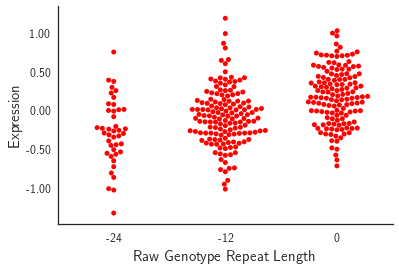

In [20]:
import seaborn as sns
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

rmgts = []
for gt in sorted(list(set(strgt["str"]))):
    if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

fig = plt.figure()
ax = fig.add_subplot(111)
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="red")
ax.set_xlabel("Raw Genotype Repeat Length", size=15)
ax.set_ylabel("Expression", size=15)
ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.suptitle("");
plt.show()
fig.savefig(os.path.join(OUTPATH, "%s_RawGT_vs_Expr_CSTB.pdf"%PREFIX))

In [21]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/s1saini/manuscript_strsnp/gtex/gtex_beagle41_chr21_multiallelic.vcf.gz

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%REF\t%TGT\n]" $VCF | \
    grep -v "\." > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

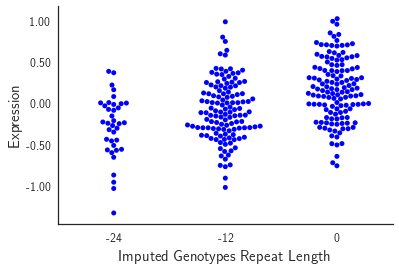

In [22]:
import re
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","ref","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

sample_gt = list()
for i in strgt.values:
    refLen = len(i[1])
    gt_bases = re.split('/|\|',i[2])
    if ('.' in gt_bases):
        gt_bases_len = 'NA'
    else:
        gt_bases_len = np.sum([(len(j) - refLen) for j in gt_bases])
    sample_gt.append([i[0], gt_bases_len])
    
strgt = pd.DataFrame.from_records(sample_gt, columns=['sample','str'])

rmgts = []
for gt in sorted(list(set(strgt["str"]))):
    if strgt[strgt["str"]==gt].shape[0] <= 3: rmgts.append(gt)
strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

fig = plt.figure()
ax = fig.add_subplot(111)
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="blue")
ax.set_xlabel("Imputed Genotypes Repeat Length", size=15)
ax.set_ylabel("Expression", size=15)
ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_title("chr%s:%s - %s"%(CHROM, START, GENE))
plt.suptitle("");
plt.show()
fig.savefig(os.path.join(OUTPATH, "%s_ImputedGT_vs_Expr_CSTB.pdf"%PREFIX))

In [23]:
CHROM=21
START=45201832

In [24]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/s1saini/manuscript_strsnp/gtex/gtex_beagle41_chr21.vcf.gz

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GT\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

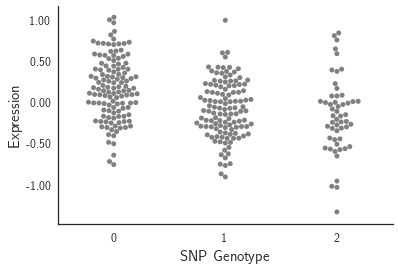

In [25]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))


rmgts = []
for gt in sorted(list(set(strgt["str"]))):
    if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

fig = plt.figure()
ax = fig.add_subplot(111)
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="gray")
ax.set_xlabel("SNP Genotype", size=15)
ax.set_ylabel("Expression", size=15)
ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_title("chr%s:%s - %s"%(CHROM, START, GENE))
plt.suptitle("");
plt.show()
fig.savefig(os.path.join(OUTPATH, "%s_BestSNP_vs_Expr_CSTB.pdf"%PREFIX))

# Multi-allelic example

In [26]:
CHROM=21
START=38733174
GENE="ENSG00000157538.9"
TISSUES="WholeBlood"

In [27]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz 

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GB\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

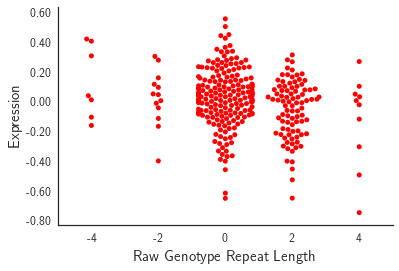

In [28]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

rmgts = []
for gt in sorted(list(set(strgt["str"]))):
    if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

t="WholeBlood"
fig = plt.figure()
ax = fig.add_subplot(111)
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="red")
ax.set_xlabel("Raw Genotype Repeat Length", size=15)
ax.set_ylabel("Expression", size=15)
ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.suptitle("");
plt.show()
fig.savefig(os.path.join(OUTPATH, "%s_RawGT_vs_Expr_Multi.pdf"%PREFIX))

In [29]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/s1saini/manuscript_strsnp/gtex/gtex_beagle41_chr21_multiallelic.vcf.gz

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%REF\t%TGT\n]" $VCF | \
    grep -v "\." > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

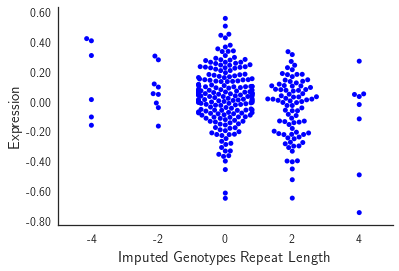

In [30]:
import re
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","ref","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

sample_gt = list()
for i in strgt.values:
    refLen = len(i[1])
    gt_bases = re.split('/|\|',i[2])
    if ('.' in gt_bases):
        gt_bases_len = 'NA'
    else:
        gt_bases_len = np.sum([(len(j) - refLen) for j in gt_bases])
    sample_gt.append([i[0], gt_bases_len])
    
strgt = pd.DataFrame.from_records(sample_gt, columns=['sample','str'])

rmgts = []
for gt in sorted(list(set(strgt["str"]))):
    if strgt[strgt["str"]==gt].shape[0] <= 3: rmgts.append(gt)
strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

t="WholeBlood"
fig = plt.figure()
ax = fig.add_subplot(111)
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="blue")
ax.set_xlabel("Imputed Genotypes Repeat Length", size=15)
ax.set_ylabel("Expression", size=15)
ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_title("chr%s:%s - %s"%(CHROM, START, GENE))
plt.suptitle("");
plt.show()
fig.savefig(os.path.join(OUTPATH, "%s_ImputedGT_vs_Expr_Multi.pdf"%PREFIX))

In [31]:
CHROM=21
START=38732581

In [32]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/s1saini/manuscript_strsnp/gtex/gtex_beagle41_chr21.vcf.gz

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GT\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

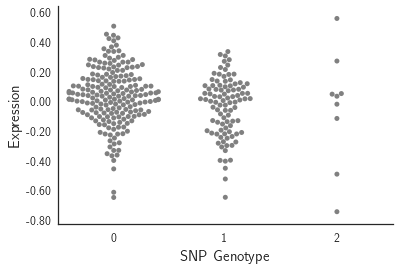

In [33]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))


rmgts = []
for gt in sorted(list(set(strgt["str"]))):
    if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

t="WholeBlood"
fig = plt.figure()
ax = fig.add_subplot(111)
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="gray")
ax.set_xlabel("SNP Genotype", size=15)
ax.set_ylabel("Expression", size=15)
ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_title("chr%s:%s - %s"%(CHROM, START, GENE))
plt.suptitle("");
plt.show()
fig.savefig(os.path.join(OUTPATH, "%s_BestSNPT_vs_Expr_Multi.pdf"%PREFIX))